In [1]:
from setup import *

# 1. Simulate FFPE samples using PCAWG mutation profiles

## 1.1 Read FFPE signatures

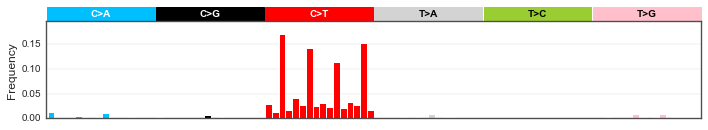

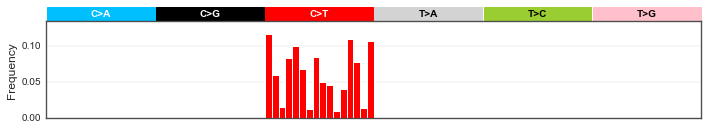

In [2]:
SBS96_plot(ffpe_sig_repaired, norm = True)
SBS96_plot(ffpe_sig_unrepaired, norm = True)

## 1.2 Read PCAWG data

PCAWG activity

In [3]:
activity = pd.read_csv("./Data/WGS_PCAWG.activities.csv")
activity.index = (activity['Cancer Types'] + "::" + activity['Sample Names']).values

SBS sig

In [4]:
SBS_sig = pd.read_csv("./Data/SBS_signatures.csv")
SBS_sig = SBS_sig.iloc[:, 2:].copy()

Mutational profiles

In [5]:
profiles = pd.read_csv("./Data/WGS_PCAWG.96.csv")
profile_values = profiles.iloc[:,2:]
profiles.head(2)

,Mutation type,Trinucleotide,Biliary-AdenoCA::SP117655,Biliary-AdenoCA::SP117556,Biliary-AdenoCA::SP117627,Biliary-AdenoCA::SP117775,Biliary-AdenoCA::SP117332,Biliary-AdenoCA::SP117712,Biliary-AdenoCA::SP117017,Biliary-AdenoCA::SP117031,...,Uterus-AdenoCA::SP94540,Uterus-AdenoCA::SP95222,Uterus-AdenoCA::SP89389,Uterus-AdenoCA::SP90503,Uterus-AdenoCA::SP92460,Uterus-AdenoCA::SP92931,Uterus-AdenoCA::SP91265,Uterus-AdenoCA::SP89909,Uterus-AdenoCA::SP90629,Uterus-AdenoCA::SP95550
0,C>A,ACA,269,114,105,217,52,192,54,196,...,117,233,94,114,257,139,404,97,250,170
1,C>A,ACC,148,56,71,123,36,139,54,102,...,90,167,59,64,268,75,255,78,188,137


## 1.3 Simulate PCAWG FFPE samples

In [6]:
def simulation(sample_indvidual, ffpe_sig, ffpe_load):
    ffpe_noise = poisson.rvs(ffpe_sig * ffpe_load)
    v =  poisson.rvs(sample_indvidual) + ffpe_noise
    return ([np.sum(ffpe_noise), v])

simulated_df_unrepaired_10_4, simulated_df_repaired_10_4 = pd.DataFrame(), pd.DataFrame()

unrepaired_noise_loads = []
repaired_noise_loads = []

for i, col in enumerate(profile_values.columns):
    npr.seed(i + 1)
    sample = profiles[col].to_numpy()
    noise_load, simulated_df_unrepaired_10_4 [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_unrepaired, 
                                                    ffpe_load = 10**4)
    
    unrepaired_noise_loads.append(noise_load)
    noise_load, simulated_df_repaired_10_4 [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_repaired, 
                                                    ffpe_load = 10**4)
    repaired_noise_loads.append(noise_load)
## write the simulated samples to Data folder
simulated_df_unrepaired_10_4.to_csv ("./Data/simulated_PCAWG_FFPE_unrepaired.csv", index = False)
simulated_df_repaired_10_4.to_csv ("./Data/simulated_PCAWG_FFPE_repaired.csv", index = False)

# 2. Correction of FFPE noise in the simulated samples
## 2.1 One example of correcting FFPE profile

We performed the same cleaning process for all simulated samples on the HPC (Apoctria, Queen Mary University of Longon) due to the long running time on local PC. Here we show an example on how it works and also correction result for one sample from colorectal cancer.

In [7]:
example_sample = "ColoRect-AdenoCA::SP21528"
cancer_type, sample_id =  example_sample.split("::")
biological_profile = profile_values[example_sample].to_numpy()
ffpe_profile = simulated_df_unrepaired_10_4[example_sample]

corrected_profile, corrected_profiles_df = correct_FFPE_profile(V = ffpe_profile.to_numpy(), 
                                                                W1 = ffpe_sig_unrepaired,
                                                                sample_id= sample_id)

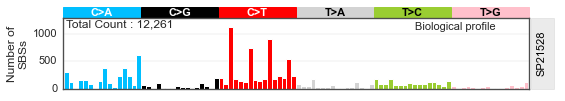

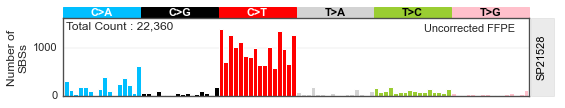

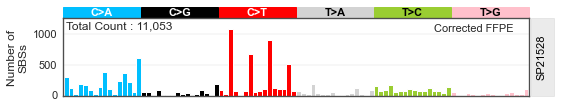

In [8]:
## plot all profiles
SBS96_plot(biological_profile, label = f"{sample_id}\n",
           name = "Biological profile", file = "./Figures/Fig2a_1.pdf",
           height = 1.6, width = 8, s = 11)

SBS96_plot(ffpe_profile, label = f"{sample_id}\n", name = "Uncorrected FFPE",
           file = "./Figures/Fig2a_2.pdf",
           height = 1.7, width = 8, s = 11)

SBS96_plot(corrected_profile, label = f"{sample_id}\n", name = "Corrected FFPE",
           file = "./Figures/Fig2a_3.pdf",
           height = 1.7, width = 8, s = 11)

In [9]:
C2T_ind = ["C>T" == t for t in profiles['Mutation type']]
n_channel = np.sum(C2T_ind)
cs_C2T = cosine_similarity(biological_profile[C2T_ind].reshape(1,n_channel), 
                               corrected_profile[C2T_ind].reshape(1,n_channel))[0][0]
cs_all = cosine_similarity(biological_profile.reshape(1,96), 
                               corrected_profile.reshape(1,96))[0][0]
print ("Accuracy (C>T, 16-channel):", cs_C2T , "\t(96channel):", cs_all)

Accuracy (C>T, 16-channel): 0.9837962205105899 	(96channel): 0.9871396921144353


**The impact of using corrected and uncorrected profiles on mutational process deconvolution in the given example**

In [10]:
df_example_act = pd.DataFrame()
channel_num = 96

active_sig_ind = activity.loc[example_sample][3:].values > 0 # select active signatures (>0) based on PCAWG activites data 
active_sig_num = np.sum(active_sig_ind)
act_sig =  SBS_sig.columns[active_sig_ind]
df_example_act['active_sig']= act_sig

npr.seed (12)    
## activities by uncorrected profile:
h, kl_loss = sig_refitting(V = ffpe_profile.to_numpy().reshape(channel_num, 1), 
                            W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)

df_example_act['Uncorrected activities'] = h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num))
    
## activities by corrected profile:
h, kl_loss = sig_refitting(V = corrected_profile.reshape(channel_num, 1), 
                               W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)
df_example_act['Corrected activities'] = h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num))
  
## True activities by biological profile:
h, kl_loss = sig_refitting(V = biological_profile.reshape(channel_num, 1), 
                               W = SBS_sig.loc[:, active_sig_ind].to_numpy(), precision = 0.99)

df_example_act['Biological activities'] = h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num))
df_example_act = df_example_act.set_index('active_sig')
df_example_act.T

active_sig,SBS1,SBS5,SBS18
Uncorrected activities,0.146341,0.743336,0.110323
Corrected activities,0.272906,0.378564,0.348530
Biological activities,0.253457,0.453907,0.292636


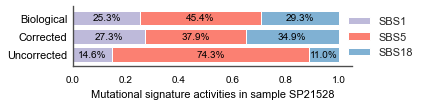

In [11]:
df_tmp = df_example_act.T
sns.set(rc={"figure.figsize":(5, 1.1)})
sns.set(style="white", color_codes=True, rc={"grid.linewidth": 0.2, 'grid.color': '.7', 'ytick.major.size': 2,
                                                 'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
ax = df_tmp.plot(kind = 'barh', stacked = True, 
                        #title = 'Percentage of mutation subtypes', 
                        mark_right = True,
                        width = 0.8,
                        color = sns.color_palette("Set3")[2:5])
ax.legend(bbox_to_anchor=(0.95, 1),frameon = False)
plt.yticks(np.arange(len(df_tmp.index)), [i.split(" ")[0] for i in df_tmp.index], 
           color = "black")

df_rel = df_tmp * 100

text_color = ['black','black','black']
for j,n in enumerate(df_rel): 
    for i, (cs, ab, pc) in enumerate(zip(df_tmp.cumsum(1)[n],  
                                         df_tmp[n], df_rel[n])): 
        plt.text (cs - ab / 2, i, str(np.round(pc, 1)) + '%',  
                 va = 'center', ha = 'center', color = text_color[j], size = 10)
sns.despine()
plt.xticks (size = 10, color = "black")
plt.xlabel("Mutational signature activities in sample " + sample_id, color = "black", size = 11)
plt.savefig("./Figures/Fig2b.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 2.2 Correction results for all simulated FFPE samples

**NOTE:** The correction process is the same for all PCAWG samples as shown in the above example. To save time, we did parallel-run in our local HPC cluster. Here, we will read the collected results for all samples from the cluster.

### 2.2.1 Comparing correction accuracy using 96-channel (all mutations) versus using 16-channel C>T mutations

Because FFPE artefacts are mostly distributed in C>T channels, our correction method will subtract noise mutaion counts mostly also from C>T channels. Therefore, using all 96-channel will increase the accuracy slightly, but this increase is very minor. So we focus on on C>T channels for accuracy calculation, which is more precise.

In [12]:
## unrepaired FFPE:
unrepaired_profiles_corrected = pd.read_csv("./Data/unrepaired_profiles_corrected.csv", sep ="\t")

## Repaired FFPEs:
repaired_profiles_corrected = pd.read_csv("./Data/repaired_profiles_corrected.csv", sep ="\t")

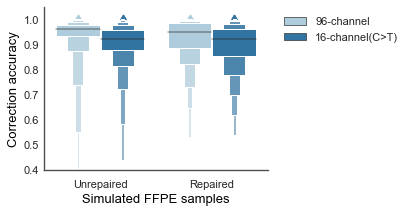

In [13]:
## 96-channel
C2T_ind = ["C>T" == t for t in profiles['Mutation type']]

n_channel = unrepaired_profiles_corrected.shape[0]
## unrepaired
accuracy = [cosine_similarity(profile_values[col].to_numpy().reshape(1,n_channel), 
                        unrepaired_profiles_corrected[col].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in unrepaired_profiles_corrected.columns[1:]]
group = ["Unrepaired"] * len(unrepaired_profiles_corrected.columns[1:])

## repaired
accuracy += [cosine_similarity(profile_values[col].to_numpy().reshape(1,n_channel), 
                        repaired_profiles_corrected[col].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in unrepaired_profiles_corrected.columns[1:]]

group += ["Repaired"] * len(unrepaired_profiles_corrected.columns[1:])
labels = ["96-channel"] * len(unrepaired_profiles_corrected.columns[1:]) * 2

## 16-channel
n_channel = np.sum(C2T_ind)
## unrepaired
accuracy += [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                        unrepaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in unrepaired_profiles_corrected.columns[1:]]
group += ["Unrepaired"] * len(unrepaired_profiles_corrected.columns[1:])

## repaired
accuracy += [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                        repaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                        for col in repaired_profiles_corrected.columns[1:]]
group += ["Repaired"] * len(unrepaired_profiles_corrected.columns[1:])
labels += ["16-channel(C>T)"] * len(unrepaired_profiles_corrected.columns[1:]) * 2

## for plotting
f, ax = plt.subplots (figsize = (4,3))
df_acc_diff_channel = pd.DataFrame()
accuracy_changes = pd.DataFrame({"Group": group,
                                 "Label": labels,
                                 "Accuracy":accuracy})

sns.boxenplot(x = "Group", y = "Accuracy", data = accuracy_changes, hue = "Label", 
                       palette= sns.color_palette("Paired")[0:2], ax = ax)
ax.set_ylim (0.4,1.05)
#ax.set_xticklabels(['Before\ncorrection','After\ncorrection'])
ax.set_xlabel ("Simulated FFPE samples", color = "black", size = 13)
ax.set_ylabel("Correction accuracy", size = 13, color = "black")
plt.legend(bbox_to_anchor=(1.03, 1),frameon = False)
sns.despine()
plt.savefig ("./Figures/SFig8.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

### 2.2.2 Collecting correction results for unrepaired FFPEs

In [14]:
## collecting accuracy
C2T_ind = ["C>T" in t for t in profiles['Mutation type']]
n_channel = np.sum(C2T_ind)
accuracy_unrepaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                        unrepaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                       for col in unrepaired_profiles_corrected.columns[1:]]

## computing similarities between FFPE sig (the noise) and the original profile(the signal)
similarity_unrepaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                            ffpe_sig_unrepaired[C2T_ind].reshape(1,n_channel))[0][0] 
                         for col in unrepaired_profiles_corrected.columns[1:]]

## Build dataframe
unrepaired_stat = pd.DataFrame()
unrepaired_stat['Samples'] = profiles.columns[2:]
unrepaired_stat['Cancer_type'] = [col.split("::")[0] for col in profiles.columns[2:]]

unrepaired_stat['Correction_accuracy'] = accuracy_unrepaired
unrepaired_stat['Similarity_FFPEsig_original'] = similarity_unrepaired


## label the similarity group: top 10% as high, bottom 10% as low, others are middle
sim_values_unrepaired = unrepaired_stat.Similarity_FFPEsig_original.values
sim_lower, sim_upper = np.quantile(sim_values_unrepaired, [0.1,0.9])
unrepaired_stat['similarity_label'] = "Middle"
unrepaired_stat['similarity_label'].values[sim_values_unrepaired < sim_lower] = "Low"
unrepaired_stat['similarity_label'].values[sim_values_unrepaired > sim_upper] = "High"


load_values = profiles.iloc[:,2:].loc[C2T_ind,:].sum()
unrepaired_stat['Mutationload_C2T'] = load_values.values
unrepaired_stat['noise_load'] = unrepaired_noise_loads
unrepaired_stat['SNR'] = unrepaired_stat['Mutationload_C2T']/unrepaired_stat['noise_load']
## label the mutation load group: top 10% as high, bottom 10% as low, others are middle
load_lower, load_upper = np.quantile(unrepaired_stat['SNR'], [0.1,0.9])

unrepaired_stat['SNR_label'] = "Middle"
unrepaired_stat['SNR_label'].values[unrepaired_stat['SNR'] < load_lower] = "Low"
unrepaired_stat['SNR_label'].values[unrepaired_stat['SNR'] > load_upper] = "High"
unrepaired_stat.head(2)

,Samples,Cancer_type,Correction_accuracy,Similarity_FFPEsig_original,similarity_label,Mutationload_C2T,noise_load,SNR,SNR_label
0,Biliary-AdenoCA::SP117655,Biliary-AdenoCA,0.950382,0.796766,Middle,5419,10118,0.535580,Middle
1,Biliary-AdenoCA::SP117556,Biliary-AdenoCA,0.965307,0.573458,Middle,1998,9901,0.201798,Middle


### 2.2.3 Collecting correction results for repaired FFPEs

In [15]:
## collecting accuracy
accuracy_repaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                    repaired_profiles_corrected[col][C2T_ind].to_numpy().reshape(1, n_channel))[0][0] 
                    for col in repaired_profiles_corrected.columns[1:]]

## computing similarities between FFPE sig (the noise) and the original profile(the signal)
similarity_repaired = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1, n_channel), 
                      ffpe_sig_repaired[C2T_ind].reshape(1,n_channel))[0][0] 
                      for col in repaired_profiles_corrected.columns[1:]]

## Build dataframe
repaired_stat = pd.DataFrame()
repaired_stat['Samples'] = profiles.columns[2:]
repaired_stat['Cancer_type'] = [col.split("::")[0] for col in profiles.columns[2:]]

repaired_stat['Correction_accuracy'] = accuracy_repaired
repaired_stat['Similarity_FFPEsig_original'] = similarity_repaired


## label the similarity group: top 10% as high, bottom 10% as low, others are middle
sim_values_repaired = repaired_stat.Similarity_FFPEsig_original.values
sim_lower, sim_upper = np.quantile(sim_values_repaired, [0.1,0.9])
repaired_stat['similarity_label'] = "Middle"
repaired_stat['similarity_label'].values[sim_values_repaired < sim_lower] = "Low"
repaired_stat['similarity_label'].values[sim_values_repaired > sim_upper] = "High"


load_values = profiles.iloc[:,2:].loc[C2T_ind,:].sum()
repaired_stat['Mutationload_C2T'] = load_values.values
repaired_stat['noise_load'] = repaired_noise_loads
repaired_stat['SNR'] = repaired_stat['Mutationload_C2T']/repaired_stat['noise_load']
## label the mutation load group: top 10% as high, bottom 10% as low, others are middle
load_lower, load_upper = np.quantile(repaired_stat['SNR'], [0.1,0.9])

repaired_stat['SNR_label'] = "Middle"
repaired_stat['SNR_label'].values[repaired_stat['SNR'] < load_lower] = "Low"
repaired_stat['SNR_label'].values[repaired_stat['SNR'] > load_upper] = "High"

repaired_stat.head(2)

,Samples,Cancer_type,Correction_accuracy,Similarity_FFPEsig_original,similarity_label,Mutationload_C2T,noise_load,SNR,SNR_label
0,Biliary-AdenoCA::SP117655,Biliary-AdenoCA,0.953653,0.648274,Middle,5419,9957,0.544240,Middle
1,Biliary-AdenoCA::SP117556,Biliary-AdenoCA,0.862878,0.939527,High,1998,10068,0.198451,Middle


### 2.2.4 Overall cormediann accuracy

In [16]:
cutoffs = np.array([0.8, 0.825,0.85,0.875,0.9])
passed_ratios_unrepaired = []
passed_counts_unrepaired = []
passed_ratios_repaired = []
passed_counts_repaired = []

for i in cutoffs:
    passed_ratio_tmp = np.sum(unrepaired_stat['Correction_accuracy'] > i) / unrepaired_stat.shape[0]
    passed_ratios_unrepaired.append(passed_ratio_tmp)
    passed_counts_unrepaired.append(np.sum(unrepaired_stat['Correction_accuracy'] > i))
    
    passed_ratio_tmp = np.sum(repaired_stat['Correction_accuracy'] > i) / repaired_stat.shape[0]
    passed_ratios_repaired.append(passed_ratio_tmp)
    passed_counts_repaired.append(np.sum(repaired_stat['Correction_accuracy'] > i))
    
passed_ratio_df = pd.DataFrame({"Cutoffs": cutoffs, "unrepaired_ratio" : passed_ratios_unrepaired,
                                'unrepaired_counts': passed_counts_unrepaired,
                               "repaired_ratio" : passed_ratios_repaired,
                               "repaired_counts" : passed_counts_repaired})
passed_ratio_df

,Cutoffs,unrepaired_ratio,unrepaired_counts,repaired_ratio,repaired_counts
0,0.800,0.890647,2476,0.851439,2367
1,0.825,0.862590,2398,0.808633,2248
2,0.850,0.821583,2284,0.758273,2108
3,0.875,0.755755,2101,0.689568,1917
4,0.900,0.636331,1769,0.601079,1671


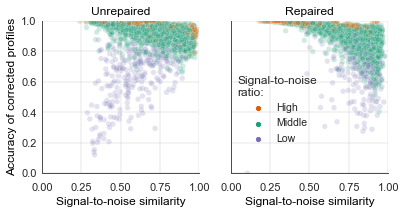

In [17]:
## overall correction accuracy
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})
f, (ax1, ax2) = plt.subplots(1,2, figsize=(6.2, 2.8), sharey = True, sharex =True)

sns.scatterplot(x = "Similarity_FFPEsig_original", y = "Correction_accuracy", 
                hue = "SNR_label", palette = "Dark2",
                data = unrepaired_stat,  alpha = 0.2, s = 30, ax = ax1)

handles, labels = ax1.get_legend_handles_labels()

ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.legend ('', frameon = False)
ax1.set_xlabel("Signal-to-noise similarity",
           size = 12, color = "black")
ax1.set_ylabel("Accuracy of corrected profiles", size = 12, color = "black")
ax1.set_title ("Unrepaired", color = "black", size = 12)

sns.scatterplot(x = "Similarity_FFPEsig_original", y = "Correction_accuracy", 
                hue = "SNR_label", palette = "Dark2",
                data = repaired_stat,  alpha = 0.2, s = 30, ax = ax2, legend = None )

ax2.legend([handles[2], handles[1], handles[3]],
           [labels[2], labels[1], labels[3]], 
           bbox_to_anchor=(0.61, 0.7),
           frameon = False, title = "Signal-to-noise\nratio:", 
           fontsize = 10.5, markerscale = 0.7, ncol = 1)

ax2.set_xlim(0,1)
ax2.set_ylim(0,1)
sns.despine()
ax2.set_xlabel ("Signal-to-noise similarity",
                size = 12, color = "black")
ax2.set_title ("Repaired", color = "black", size = 12)
plt.savefig("./Figures/Fig2c.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

In [18]:
unrepaired_mean = np.mean(unrepaired_stat['Correction_accuracy'])
unrepaired_CI = np.around(CI(unrepaired_stat['Correction_accuracy']),3)
print ("Unrepaired FFPE correction")
print (f'Mean:{unrepaired_mean:.3f}, 95% CI:{unrepaired_CI}')

repaired_mean = np.mean(repaired_stat['Correction_accuracy'])
repaired_CI = np.around(CI(repaired_stat['Correction_accuracy']),3)
print ("Repaired FFPE correction")
print (f'Mean:{repaired_mean:.3f}, 95% CI:{repaired_CI}')

## output well-corrected samples
well_corrected_samples_unrepaired_df = unrepaired_stat.loc[unrepaired_stat['Correction_accuracy'] > 0.9, :]
well_corrected_samples_repaired_df = repaired_stat.loc[repaired_stat['Correction_accuracy'] > 0.9, :]

well_corrected_samples_unrepaired_df.to_csv("./Data/well_corrected_unrepaired_FFPE.csv",
                                            sep = "\t", index = None)
well_corrected_samples_repaired_df.to_csv("./Data/well_corrected_repaired_FFPE.csv",
                                            sep = "\t", index = None)

Unrepaired FFPE correction
Mean:0.895, 95% CI:[0.89  0.899]
Repaired FFPE correction
Mean:0.890, 95% CI:[0.886 0.894]


 ## 2.3 Possible factors affecting the noise correction accuracy

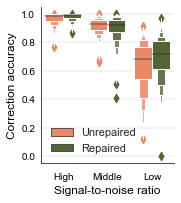

In [19]:
unrepaired_stat['label'] = "Unrepaired"
repaired_stat['label'] = "Repaired"
combined_stat = pd.concat((unrepaired_stat,repaired_stat))

sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})
#ax.set(yscale="log")
sns.catplot(x = 'SNR_label', y = 'Correction_accuracy', kind = 'boxen', hue = "label",legend= None,
            data = combined_stat,height = 3, aspect = 0.9,
            order = ['High', 'Middle', 'Low'],palette=['coral','darkolivegreen'])
plt.ylabel ("Correction accuracy",  size = 12, color = "black") 
plt.xlabel("Signal-to-noise ratio",size = 12, color = "black")
plt.xticks (size = 10, color = "black")
plt.yticks (size = 10, color = "black")
#plt.ylim(0.2, 1.05)

plt.legend(loc = "lower left",frameon = False)
plt.setp(f.lines, color=".9")
plt.savefig("./Figures/Fig2e.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

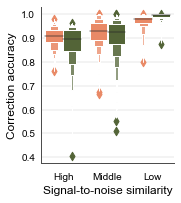

In [20]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3',
                                                 'axes.linewidth': 1})
df_tmp = combined_stat.loc[list(combined_stat.SNR_label.values !="Low"),:]
sns.catplot(x = 'similarity_label', y = 'Correction_accuracy', kind = 'boxen', hue = "label",legend= None,
            data = df_tmp, height = 3, aspect = .9,
            order = ['High', 'Middle', 'Low'],palette=['coral','darkolivegreen'])
plt.ylabel ("Correction accuracy",  size = 12, color = "black")
plt.xlabel("Signal-to-noise similarity", 
           size = 12, color = "black")
plt.xticks (size = 10, color = "black")
plt.yticks (size = 10, color = "black")
plt.savefig("./Figures/Fig2f.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 2.4 Correction accuracy grouped by main cancer types

In [21]:
## main cancer types include more than 20 samples within the cancer type:
cancer_types_count = unrepaired_stat.groupby('Cancer_type')['Samples'].count()
main_cancer_types = cancer_types_count.index[cancer_types_count > 20]

unrepaired_stat_filtered = unrepaired_stat.loc[[ctype in main_cancer_types for 
                                                ctype in unrepaired_stat.Cancer_type],:].copy()

repaired_stat_filtered = repaired_stat.loc[[ctype in main_cancer_types for 
                                                ctype in repaired_stat.Cancer_type],:].copy()

## combine unrepaired and repaired FFPE data together
repaired_stat_filtered['label'] = "Repaired"
unrepaired_stat_filtered['label'] = "Unrepaired"
combined_stat_mainCancerTypes = pd.concat((unrepaired_stat_filtered, repaired_stat_filtered))
combined_stat_mainCancerTypes.head(2)

,Samples,Cancer_type,Correction_accuracy,Similarity_FFPEsig_original,similarity_label,Mutationload_C2T,noise_load,SNR,SNR_label,label
0,Biliary-AdenoCA::SP117655,Biliary-AdenoCA,0.950382,0.796766,Middle,5419,10118,0.535580,Middle,Unrepaired
1,Biliary-AdenoCA::SP117556,Biliary-AdenoCA,0.965307,0.573458,Middle,1998,9901,0.201798,Middle,Unrepaired


### 2.4.1 Sorted cancer types based on overall mean accuracy

In [22]:
combined_stat_mainCancerTypes['MutationLoad'] = [profile_values[sample][C2T_ind].sum() 
                                                 for sample in combined_stat_mainCancerTypes['Samples'].values]
combined_stat_mainCancerTypes.groupby ('Cancer_type').mean().sort_values(by="Correction_accuracy",
                                                                        ascending = False)

,Correction_accuracy,Similarity_FFPEsig_original,Mutationload_C2T,noise_load,SNR,MutationLoad
Cancer_type,,,,,,
Skin-Melanoma,0.982948,0.547919,96361.869159,9992.308411,9.643634,96361.869159
Bladder-TCC,0.967600,0.602057,8628.260870,10011.434783,0.861683,8628.260870
Lung-SCC,0.959504,0.689234,9248.437500,9999.458333,0.924795,9248.437500
ColoRect-AdenoCA,0.957854,0.678862,40840.500000,9994.891667,4.092031,40840.500000
CNS-GBM,0.956664,0.663305,8701.195122,10007.695122,0.860835,8701.195122
Uterus-AdenoCA,0.938631,0.710636,23086.470588,10008.500000,2.300573,23086.470588
Liver-HCC,0.937425,0.742861,2669.822086,10000.200920,0.266940,2669.822086
Head-SCC,0.933200,0.686242,5544.666667,9996.096491,0.554984,5544.666667
Lung-AdenoCA,0.928200,0.702051,7280.131579,10008.131579,0.727507,7280.131579


### 2.4.2 Well-correction samples (accuracy > 0.9)

In [23]:
## Compute the percentage of well reconstructed samples in each type 
def collect_well_reconstructed_ratio (df):
    ratios = []
    types = []
    cutoff = 0.90
    for ctype in df["Cancer_type"].unique():
        passed = sum(df.loc[df.Cancer_type == ctype, "Correction_accuracy"] >= cutoff)
        total = sum(df.Cancer_type == ctype)
        ratio = passed/total
        ratios.append(ratio)
        types.append(ctype)
    ratio_df = pd.DataFrame({'Cancer_type':types, 'ratios': ratios})
    ratio_df = ratio_df.sort_values(by=['ratios'], ascending = False)
    return (ratio_df)

unrepaired_ratio_df = collect_well_reconstructed_ratio(df = unrepaired_stat_filtered.copy())
repaired_ratio_df = collect_well_reconstructed_ratio(df = repaired_stat_filtered.copy())

well_constructed_df = unrepaired_ratio_df.merge(repaired_ratio_df,on = 'Cancer_type', suffixes = ("_unrepaired",
                                                                                                  "_repaired"))
well_constructed_df_sorted = well_constructed_df.sort_values('ratios_unrepaired', ascending = False)

p_values = []
for ct in well_constructed_df_sorted.Cancer_type:
    x1 = unrepaired_stat_filtered.loc[unrepaired_stat_filtered.Cancer_type == ct,
                                 :]['Correction_accuracy'].values
    x2 = repaired_stat_filtered.loc[repaired_stat_filtered.Cancer_type == ct,
                                 :]['Correction_accuracy'].values
    t, p = mannwhitneyu(x1, x2, alternative='two-sided')
    p_values.append(p)

well_constructed_df_sorted['p_value'] = p_values

p_labels = []
for p in well_constructed_df_sorted['p_value']:
    if p < 0.001:
        p_labels.append("***")
    elif p < 0.01 and p > 0.001:
        p_labels.append("**")
    elif p < 0.05 and p > 0.01:
        p_labels.append("*")
    else:
        p_labels.append("")
        
well_constructed_df_sorted['labels'] = p_labels

unrepaired_ratio_num = (np.around(well_constructed_df_sorted.ratios_unrepaired,
                                  2) * 100 ).astype("int").values
repaired_ratio_num = (np.around(well_constructed_df_sorted.ratios_repaired,
                                  2) * 100 ).astype("int").values

well_constructed_df_sorted

,Cancer_type,ratios_unrepaired,ratios_repaired,p_value,labels
0,CNS-GBM,1.000000,0.926829,9.307816e-10,***
1,ColoRect-AdenoCA,1.000000,0.933333,1.698300e-05,***
2,Panc-AdenoCA,0.958506,0.605809,1.601219e-43,***
3,Bladder-TCC,0.956522,0.869565,8.951306e-01,
4,Uterus-AdenoCA,0.941176,0.647059,1.015780e-03,**
5,Skin-Melanoma,0.925234,0.962617,1.550511e-01,
6,Eso-AdenoCA,0.877551,0.744898,6.664723e-05,***
7,Head-SCC,0.877193,0.631579,2.252154e-01,
8,Lung-AdenoCA,0.842105,0.736842,2.138601e-02,*
9,Lung-SCC,0.833333,1.000000,2.403574e-11,***


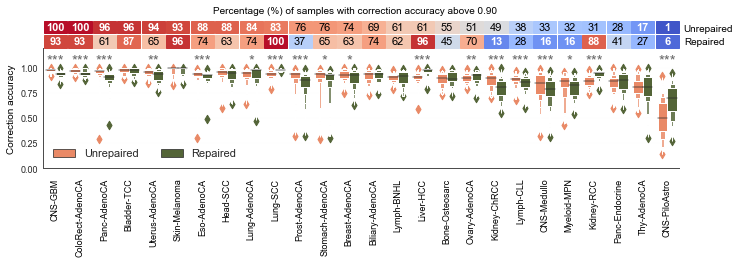

In [24]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.01, 'grid.color': '.7', 
                                                 'ytick.major.size': 2, 'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})

sns.catplot(x = 'Cancer_type', y = 'Correction_accuracy', palette=['coral','darkolivegreen'],
            data = combined_stat_mainCancerTypes, order = well_constructed_df_sorted.Cancer_type.values, 
            hue = "label",legend= None, kind = 'boxen', height = 2.5, aspect = 4,)
plt.xticks(rotation = 90, size = 9, color = "black")
plt.yticks( size = 9)

plt.xlabel ("")
plt.ylim(0, 1.2)
plt.legend(loc = "lower left", ncol = 2, frameon = False)
plt.ylabel ("Correction accuracy",  size = 10, color = "black")
cutoff = 0.9
Targeted_cancers = unrepaired_ratio_df.Cancer_type.values
length = len(Targeted_cancers)
for i in range(length):
    ## bottom pannel color bars 
    left, width = 0 + 1/length * i + 0.001, 1/length - 0.002        
    bottom, height = 1.12, 0.10
    right = left + width
    top = bottom + height
    ax = plt.gca()
    col_ind = unrepaired_ratio_num[i]
    colors =sns.color_palette("coolwarm", np.max(unrepaired_ratio_num) +1) 
    p = plt.Rectangle((left, bottom), width, height, fill=True, color = colors[col_ind])
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    
    if col_ind > 20 and col_ind < 80:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), unrepaired_ratio_num[i], 
            color = "black", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), unrepaired_ratio_num[i], 
            color = "w",weight = "bold", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    
    ax.text(0.5 * (left + right), 0.38 * (bottom + top), well_constructed_df_sorted['labels'][i], 
            color = "dimgrey", size = 15,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    ## top pannel color bars
    left, width = 0 + 1/length * i + 0.001, 1/length - 0.002
        
    bottom, height = 1.003, 0.10
    right = left + width
    top = bottom + height
    ax = plt.gca()
    col_ind = repaired_ratio_num[i]
    colors =sns.color_palette("coolwarm", np.max(repaired_ratio_num) +1) 
    p = plt.Rectangle((left, bottom), width, height, fill=True, color = colors[col_ind])
    p.set_transform(ax.transAxes)
    p.set_clip_on(False)
    ax.add_patch(p)
    
    if col_ind > 20 and col_ind < 80:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), repaired_ratio_num[i], 
            color = "black", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), repaired_ratio_num[i], 
            color = "w",weight = "bold", size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
## top pannel annotation
ax.text(0.53*(left + right), 0.5 *(bottom + top), "Repaired", 
            color = "black", size = 10,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)   
## bottom pannel annotation
ax.text(0.533*(left + right), 0.55 *(bottom + top), "Unrepaired", 
            color = "black", size = 10,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.text(0.25*(left + right), 0.62 *(bottom + top), 
        f"Percentage (%) of samples with correction accuracy above {cutoff:.2f}", 
        color = "black", size = 10,
        horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
plt.savefig("./Figures/Fig2d.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 2.5 Correction accuracy with increasing FFPE noise load

### 2.5.1 Simulating data

We next evaluated how FFPEsig performance depends on SNR by generating synthetic FFPE samples with increasing levels of noise.

In [25]:
unrepaired_noise_loads_all = []
repaired_noise_loads_all = []

for level, load in zip([1,3,4,5],[10**3, 5*10**4, 10**5, 10**6]):
    simulated_df_unrepaired, simulated_df_repaired = pd.DataFrame(), pd.DataFrame()
    for i, col in enumerate(profile_values.columns):
        npr.seed(i + 1)
        sample = profile_values[col].to_numpy()
        noise_load, simulated_df_unrepaired [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_unrepaired, 
                                                    ffpe_load = load)
        unrepaired_noise_loads_all.append(noise_load)
        
        noise_load, simulated_df_repaired [col] = simulation(sample_indvidual = sample, 
                                                    ffpe_sig = ffpe_sig_repaired, 
                                                    ffpe_load = load)
        repaired_noise_loads_all.append(noise_load)
        
    ## write the simulated samples to Data folder
    simulated_df_unrepaired.to_csv ("./Data/Different_FFPEloads/simulated_PCAWG_FFPE_unrepaired_L" + 
                                    str(level) + ".csv", index = False)
    simulated_df_repaired.to_csv ("./Data/Different_FFPEloads/simulated_PCAWG_FFPE_repaired_L" + 
                                    str(level) + ".csv", index = False)

## Level 2 noise is 10**4, the same with previous simulated results:    
simulated_df_unrepaired_10_4.to_csv (
    "./Data/Different_FFPEloads/simulated_PCAWG_FFPE_unrepaired_L2.csv",index = False)
simulated_df_repaired_10_4.to_csv (
    "./Data/Different_FFPEloads/simulated_PCAWG_FFPE_repaired_L2.csv",index = False)


### 2.5.2 Read the corrected results

The correction on noise-changed samples is performed on local HPC cluster.

In [26]:
cancer_list, sample_list, accuracy_list, level_list, ffpe_load_list, label_list = [], [], [], [], [], []

path = "./Data/Different_FFPEloads/"

for label in ['unrepaired', 'repaired']:
    for level, ffpe_load in zip(['L1','L2','L3','L4','L5'],[10**3, 10**4, 5*10**4, 10**5, 10**6]): 
        corrected_profiles_DiffLevel = pd.read_csv(path + label + "_profiles_corrected_" + level +".csv",
                                          sep = "\t")

        cancer = [col.split("::")[0] for col in corrected_profiles_DiffLevel.columns[1:]]
        cancer_list += cancer

        sample = [col.split("::")[1] for col in corrected_profiles_DiffLevel.columns[1:]]
        sample_list += sample
        n_channel = np.sum(C2T_ind)
        accuracy_correction = [cosine_similarity(profile_values[col][C2T_ind].to_numpy().reshape(1,n_channel), 
                                corrected_profiles_DiffLevel[col][C2T_ind].to_numpy().reshape(1,n_channel))[0][0] 
                               for col in corrected_profiles_DiffLevel.columns[1:]]
        accuracy_list += accuracy_correction

        level_list += [level] * len(accuracy_correction)
        ffpe_load_list += [ffpe_load] * len(accuracy_correction)
        label_list += [label] * len(accuracy_correction)

## making dataframe using the collected data        
correction_stats_DiffLevel = pd.DataFrame({'Cancer_type' : cancer_list,
                                         'Sample' : sample_list,
                                         'Accuracy' : accuracy_list,
                                         'Noise_level' : level_list,
                                         'FFPE_load' : ffpe_load_list,
                                         'Label' : label_list})
## Getting SNR
correction_stats_DiffLevel['sample_id'] = correction_stats_DiffLevel["Cancer_type"] + "::" + correction_stats_DiffLevel["Sample"]

biological_C2Tmut_count = []
for s in correction_stats_DiffLevel['sample_id'].values:
    biological_C2Tmut_count.append(profile_values.loc[C2T_ind, s].sum())
correction_stats_DiffLevel['biological_C2Tmut_count'] = biological_C2Tmut_count
correction_stats_DiffLevel['SNR'] = correction_stats_DiffLevel['biological_C2Tmut_count']/correction_stats_DiffLevel['FFPE_load']

correction_stats_DiffLevel.head(2)

,Cancer_type,Sample,Accuracy,Noise_level,FFPE_load,Label,sample_id,biological_C2Tmut_count,SNR
0,Biliary-AdenoCA,SP117655,0.940219,L1,1000,unrepaired,Biliary-AdenoCA::SP117655,5419,5.419
1,Biliary-AdenoCA,SP117556,0.938982,L1,1000,unrepaired,Biliary-AdenoCA::SP117556,1998,1.998


## 2.6 Getting the mean correction accuracy of four groups of sample over different noise levels

Slice the sample into 10 batches-based on an increasing order of biological mutation load.

In [27]:
batch_size = 278
all_batch_labels = []
batch_labels = ["Q" + str (i) for i in range(1,11)]
for i in range (len(batch_labels)):
    l = batch_labels[i]
    all_batch_labels = all_batch_labels + [l] * batch_size

sample_batch = pd.DataFrame()
sample_batch['samples'] = profile_values.loc[C2T_ind,:].sum().sort_values().index
sample_batch['label'] = all_batch_labels
sample_batch.head()

,samples,label
0,Myeloid-AML::SP116919,Q1
1,Stomach-AdenoCA::SP135310,Q1
2,Thy-AdenoCA::SP85818,Q1
3,Prost-AdenoCA::SP125579,Q1
4,CNS-PiloAstro::SP79327,Q1


Assigne the samples based on the above batch-information to four categories, Q:0-10%, Q:10%-50%, Q:50%-90% and Q:90%-100%.

In [28]:
Q_labels = []
for s in correction_stats_DiffLevel['sample_id'].values:
    Q_labels.append(sample_batch["label"][sample_batch['samples'] == s].values[0])
correction_stats_DiffLevel['Q_labels'] = Q_labels

q_merged = []
for ql in correction_stats_DiffLevel['Q_labels'].values:
    perc = int (ql[1:])
    if perc == 1:
        q_merged.append("Q:0-10%")
    elif perc > 1 and perc <= 5:
        q_merged.append("Q:10%-50%")
    elif perc >5 and perc <=9 :
        q_merged.append("Q:50%-90%")
    else:
        q_merged.append("Q:90%-100%")
correction_stats_DiffLevel['Q_labels_Merged'] = q_merged
correction_stats_DiffLevel.head()

,Cancer_type,Sample,Accuracy,Noise_level,FFPE_load,Label,sample_id,biological_C2Tmut_count,SNR,Q_labels,Q_labels_Merged
0,Biliary-AdenoCA,SP117655,0.940219,L1,1000,unrepaired,Biliary-AdenoCA::SP117655,5419,5.419,Q9,Q:50%-90%
1,Biliary-AdenoCA,SP117556,0.938982,L1,1000,unrepaired,Biliary-AdenoCA::SP117556,1998,1.998,Q6,Q:50%-90%
2,Biliary-AdenoCA,SP117627,0.918768,L1,1000,unrepaired,Biliary-AdenoCA::SP117627,3029,3.029,Q8,Q:50%-90%
3,Biliary-AdenoCA,SP117775,0.960271,L1,1000,unrepaired,Biliary-AdenoCA::SP117775,5226,5.226,Q9,Q:50%-90%
4,Biliary-AdenoCA,SP117332,0.988058,L1,1000,unrepaired,Biliary-AdenoCA::SP117332,1400,1.400,Q5,Q:10%-50%


In [29]:
correction_stats_DiffLevel.loc[correction_stats_DiffLevel['SNR'] > 0.1].groupby("Label").mean()

,Accuracy,FFPE_load,biological_C2Tmut_count,SNR
Label,,,,
repaired,0.941308,18802.008336,15707.980485,4.380399
unrepaired,0.935060,18802.008336,15707.980485,4.380399


### 2.6.1 Unrepaired FFPE

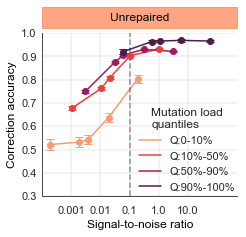

In [30]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})

cor_stats_group2 = correction_stats_DiffLevel.groupby (['Label', 'Q_labels_Merged'])

f, ax = plt.subplots( figsize=(3.5, 3), gridspec_kw={ 'wspace': 0.3, 'hspace' : 0.6})
qc = sns.color_palette("rocket",4)
qc = qc[::-1]

for i, q in enumerate(["Q:0-10%", "Q:10%-50%", "Q:50%-90%", "Q:90%-100%"]):
    tmp = cor_stats_group2.get_group (("unrepaired", q))
    tmp_mean = tmp.groupby("Noise_level").mean()
    level_lower_limits = tmp.groupby("Noise_level")['Accuracy'].apply(lambda x: CI(x)[0])
    level_higher_limits = tmp.groupby("Noise_level")['Accuracy'].apply(lambda x: CI(x)[1])
    
    ax.plot (np.log10(tmp_mean['SNR']), tmp_mean['Accuracy'], label = q, color = qc[i])
    ax.errorbar(np.log10(tmp_mean['SNR']), tmp_mean['Accuracy'], 
             yerr = [ tmp_mean['Accuracy'] - level_lower_limits, level_higher_limits -  tmp_mean['Accuracy']], 
             fmt = "o", capsize=4, elinewidth = 1, markeredgewidth = 1,
             color = qc[i])
    
##### adding name    
left, width,  bottom, height = 0, 1, 1.03, 0.13
right = left + width
top = bottom + height
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=True, color = 'coral',alpha = 0.7)
p.set_transform(ax.transAxes)
p.set_clip_on(False)
ax.add_patch(p)    
ax.text(0.5 * (left + right), 0.5 * (bottom + top), "Unrepaired", color = 'black',size = 12,
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.set_xticks(np.array([-3, -2, -1, 0,1]))
ax.set_xticklabels(np.round (10.0**np.array([-3, -2, -1, 0,1]),3))
ax.set_xlabel ("Signal-to-noise ratio",size = 12, color = "black")
ax.set_ylabel ("Correction accuracy",size = 12, color = "black")

#plt.legend("", frameon = False)
plt.legend(title = "Mutation load\nquantiles", frameon = False)
plt.legend(bbox_to_anchor=(0.04, 0.5, 1.0, .10),title = "Mutation load\nquantiles", frameon = False)
sns.despine()
plt.ylim (0.3,1)
plt.xlim (np.log10(0.0001), np.log10(500))
plt.axvline(x=np.log10(0.1), alpha = 0.4, linestyle='dashed', color = "black")

plt.savefig("./Figures/Fig2g.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

### 2.6.2 Repaired FFPE

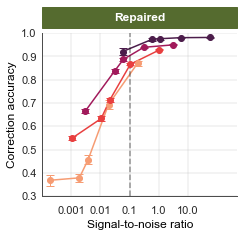

In [31]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.3, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})

cor_stats_group2 = correction_stats_DiffLevel.groupby (['Label', 'Q_labels_Merged'])

f, ax = plt.subplots( figsize=(3.5, 3), gridspec_kw={ 'wspace': 0.3, 'hspace' : 0.6})
qc = sns.color_palette("rocket",4)
qc = qc[::-1]

for i, q in enumerate(["Q:0-10%", "Q:10%-50%", "Q:50%-90%", "Q:90%-100%"]):
    tmp = cor_stats_group2.get_group (("repaired", q))
    tmp_mean = tmp.groupby("Noise_level").mean()
    level_lower_limits = tmp.groupby("Noise_level")['Accuracy'].apply(lambda x: CI(x)[0])
    level_higher_limits = tmp.groupby("Noise_level")['Accuracy'].apply(lambda x: CI(x)[1])
    
    ax.plot (np.log10(tmp_mean['SNR']), tmp_mean['Accuracy'], label = q, color = qc[i])
    ax.errorbar(np.log10(tmp_mean['SNR']), tmp_mean['Accuracy'], 
             yerr = [ tmp_mean['Accuracy'] - level_lower_limits, level_higher_limits -  tmp_mean['Accuracy']], 
             fmt = "o", capsize=4, elinewidth = 1, markeredgewidth = 1,
             color = qc[i])
##### adding name
left, width,  bottom, height = 0, 1, 1.03, 0.13
right = left + width
top = bottom + height
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=True, color = 'darkolivegreen',alpha = 1)
p.set_transform(ax.transAxes)
p.set_clip_on(False)
ax.add_patch(p)    
ax.text(0.5 * (left + right), 0.5 * (bottom + top), "Repaired", color = 'w',size = 12,weight = "bold",
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.set_xticks(np.array([-3, -2, -1, 0,1]))
ax.set_xticklabels(np.round (10.0**np.array([-3, -2, -1, 0,1]),3))
ax.set_xlabel ("Signal-to-noise ratio",size = 12, color = "black")
ax.set_ylabel ("Correction accuracy",size = 12, color = "black")

plt.legend("", frameon = False)
sns.despine()
plt.setp(f.lines, color=".9")
plt.ylim (0.3,1)
plt.xlim (np.log10(0.0001), np.log10(500))
plt.axvline(x=np.log10(0.1), alpha = 0.4, linestyle='dashed', color = "black")
plt.savefig("./Figures/Fig2h.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

# 3. Apply decision-making workflow on main set of simulation data

We next designed a decision-making flowchart that prospective users could use to decide whether their analysis would benefit from FFPEsig and whether an unrepaired or repaired protocol is more suitable for their samples. The two main factors we need to estimate is SNR and SNS.

## 3.1 Estimating average SNS between FFPE signatures with known mutation profile of a given cancer type

For SNR, we suggest to use cancer types with average SNR >0.1 based on the above analysis. For SNS, we suggest to choose the protcol which has smaller SNS: 

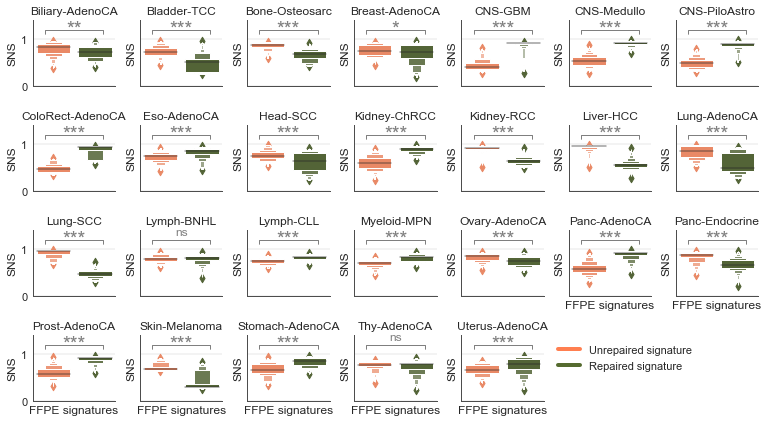

In [32]:
nrow, ncol = 4, 7
f, axs = plt.subplots(nrow,ncol, sharey = True, figsize = (13,7), 
                      gridspec_kw={ 'wspace': 0.3, 'hspace' : 0.6})
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})    

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color="coral", lw=4),
                Line2D([0], [0], color='darkolivegreen', lw=4)]

fig_ind = []
for i in range(nrow):
    for j in range(ncol):
        fig_ind.append((i,j))
n = 0
for i, ctype in enumerate(main_cancer_types):

    ax = axs[fig_ind[n]]
    n += 1
    tmp = combined_stat_mainCancerTypes.loc[combined_stat_mainCancerTypes['Cancer_type'] == ctype,:].copy()
    
    SNS_unrepaired = tmp.groupby("label").get_group("Unrepaired")['Similarity_FFPEsig_original'].values
    SNS_repaired = tmp.groupby("label").get_group("Repaired")['Similarity_FFPEsig_original'].values
    
    t, p = mannwhitneyu(SNS_repaired, SNS_unrepaired, alternative='two-sided') ## difference test
    
    ax = sns.boxenplot (x = "label", y="Similarity_FFPEsig_original", data = tmp, ax = ax,
                palette= {"Unrepaired":'coral', "Repaired":'darkolivegreen'})
    
    ## adding p value on the plot     
    x1, x2 = -0.20, 1.20
    y, h, col = 1+0.1, 0.1, 'black'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c = "black")
    if p>0.05 :
        ax.text((x1+x2)*.5, y + h +0.05, 'ns', ha='center', va='bottom', color ="grey")
    elif p<0.05 and p>0.01:      
        ax.text((x1+x2)*.5, y + h -0.2 , '*', ha='center', va='bottom', fontsize = 20, color="grey")
    elif p<0.01 and p>0.001:
        ax.text((x1+x2)*.5, y + h -0.2 , '**', ha='center', va='bottom',fontsize = 20,color="grey")
    else:
        ax.text((x1+x2)*.5, y + h -0.2 , '***', ha='center', va='bottom',fontsize = 20, color="grey")
    if n == 26:
        ax.legend (custom_lines, ["Unrepaired signature", "Repaired signature"],bbox_to_anchor=(1.05,1), 
                   frameon = False, fontsize=11, ncol = 1)
    ax.set_title(ctype)
    ax.set_xticks([])
    ax.set_ylabel("SNS")
    
    if n >= 20:
        ax.set_xlabel("FFPE signatures")
    else:
        ax.set_xlabel("")
    ax.set_ylim(0,1.4)
    sns.despine()

f.delaxes(axs[fig_ind[26]])
f.delaxes(axs[fig_ind[27]])
plt.savefig("./Figures/SFig17.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 3.2 Guided flowchart

We will use our simulated samples as a test set to re-examine the performance of FFPEsig.

In [33]:
true_SNR_level = []
est_SNR_level = []
SNS_unrepaired = []
SNS_repaired = []

flag = []
well_corrected_number = []
total_sample = []

for ctype in main_cancer_types:
    
    tmp = combined_stat_mainCancerTypes.loc[combined_stat_mainCancerTypes['Cancer_type'] == ctype,:].copy()
    
    ## median mutation count 
    ave_signal_load = np.median(tmp.loc[tmp['Mutationload_C2T']<50000]['MutationLoad'])
    obs_load = tmp['MutationLoad'] + tmp['noise_load']
    est_SNR = ave_signal_load / (obs_load - ave_signal_load)
    est_SNR_level.append(np.median(est_SNR))
    
    true_SNR_level.append(np.median(tmp.loc[tmp['Mutationload_C2T']<50000]['SNR']))
    
    a = np.median(tmp.loc[tmp['label'] == "Unrepaired",'Similarity_FFPEsig_original'])
    b = np.median(tmp.loc[tmp['label'] == "Repaired",'Similarity_FFPEsig_original'])
    SNS_unrepaired.append(a)
    SNS_repaired.append(b)
    
    if a>b :
        flag.append ("Repaired")
        well_corrected_samples = sum(tmp.loc[tmp['label'] == "Repaired",'Correction_accuracy'] > 0.9)
        well_corrected_number.append(well_corrected_samples)
        total_sample.append(sum(tmp['label'] == "Repaired"))
    
    else:
        flag.append ("Unrepaired")
        well_corrected_samples = sum(tmp.loc[tmp['label'] == "Unrepaired",'Correction_accuracy'] > 0.9)
        well_corrected_number.append(well_corrected_samples)
        total_sample.append(sum(tmp['label'] == "Unrepaired"))

In [34]:
after_selection_accuracy = pd.DataFrame()
after_selection_accuracy['cancer_type'] = main_cancer_types
after_selection_accuracy['True_SNR'] = true_SNR_level
after_selection_accuracy['Estimated_SNR'] = est_SNR_level

after_selection_accuracy['Recommendation'] = flag
after_selection_accuracy['well_corrected_samples'] = well_corrected_number
after_selection_accuracy['total_sample'] = total_sample
after_selection_accuracy.head()

,cancer_type,True_SNR,Estimated_SNR,Recommendation,well_corrected_samples,total_sample
0,Biliary-AdenoCA,0.208831,0.206902,Repaired,26,35
1,Bladder-TCC,0.619700,0.626436,Repaired,20,23
2,Bone-Osteosarc,0.100544,0.100570,Repaired,17,38
3,Breast-AdenoCA,0.160478,0.160042,Repaired,124,198
4,CNS-GBM,0.324934,0.322092,Unrepaired,41,41


## 3.3 Use SNR of 0.1 as cutoff

Cancer types which may not be suitable for correction

In [35]:
SNR_cutoff = 0.1
after_selection_accuracy['SNR_cutoff_0.1_passed'] = "Passed"
after_selection_accuracy.loc[after_selection_accuracy['Estimated_SNR'] <= 0.1,'SNR_cutoff_0.1_passed'] = "Not Passed"
after_selection_accuracy.loc[after_selection_accuracy['Estimated_SNR'] <= 0.1,:]

,cancer_type,True_SNR,Estimated_SNR,Recommendation,well_corrected_samples,total_sample,SNR_cutoff_0.1_passed
5,CNS-Medullo,0.042434,0.042689,Unrepaired,48,146,Not Passed
6,CNS-PiloAstro,0.007471,0.007492,Unrepaired,1,89,Not Passed
10,Kidney-ChRCC,0.069500,0.070429,Unrepaired,22,45,Not Passed
16,Lymph-CLL,0.074104,0.074344,Unrepaired,36,95,Not Passed
17,Myeloid-MPN,0.058830,0.059229,Unrepaired,18,56,Not Passed
20,Panc-Endocrine,0.068038,0.068817,Repaired,35,85,Not Passed
22,Skin-Melanoma,0.419582,0.066533,Repaired,103,107,Not Passed
24,Thy-AdenoCA,0.044346,0.043932,Unrepaired,8,48,Not Passed


Cancer types (passed SNR) with suggested protocol based on SBS

In [36]:
after_selection_accuracy.to_csv("./Data/Selection_of_protocols_for_mainCancerTypes.csv", index = None, sep = "\t")